In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
    (LinearRegression,
    LogisticRegression,
    Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
(train_test_split,
GridSearchCV)

In [2]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [5]:
from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary
from torchvision.io import read_image

In [6]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [11]:
import pytorch_lightning as pl

# Set seed for PyTorch
torch.manual_seed(0)

# Set seed for PyTorch Lightning
pl.seed_everything(0, workers=True)

Seed set to 0


0

In [12]:
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
ResNet50_Weights)
from torchvision.transforms import (Resize,
Normalize,
CenterCrop,
ToTensor)

In [13]:
from ISLP.torch import (SimpleDataModule,
SimpleModule,
ErrorTracker,
rec_num_workers)

In [14]:
from ISLP.torch.imdb import (load_lookup,
load_tensor,
load_sparse,
load_sequential)

In [15]:
from glob import glob
import json

In [16]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

In [17]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()

In [18]:
(X_train,
X_test,
Y_train,
Y_test) = train_test_split(X,
Y,
test_size=1/3,
random_state=1)

In [19]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()

259.71528833146294

In [20]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
('lasso', lasso)])

In [21]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100))
* lam_max}

In [22]:
cv = KFold(10,
shuffle=True,
random_state=1)
grid = GridSearchCV(lasso,
                    param_grid,
cv=cv,
scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train);

In [23]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

257.23820107995016

In [25]:
class HittersModel(nn.Module):
    def __init__(self, input_size):
        super(HittersModel , self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
        nn.Linear(input_size, 50),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(50, 1))
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [26]:
hit_model = HittersModel(X.shape[1])

In [27]:
summary(hit_model,
input_size=X_train.shape,
col_names=['input_size',
'output_size',
'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [28]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

In [29]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

In [30]:
max_num_workers = rec_num_workers()

In [31]:
hit_dm = SimpleDataModule(hit_train,
hit_test,
batch_size=32,
num_workers=min(4, max_num_workers),
validation=hit_test)

In [32]:
hit_module = SimpleModule.regression(hit_model,
metrics={'mae':MeanAbsoluteError()})

In [33]:
hit_logger = CSVLogger('logs', name='hitters')

In [34]:
hit_trainer = Trainer(deterministic=True,
max_epochs=50,
log_every_n_steps=5,
logger=hit_logger,
callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs\hitters

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [35]:
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             104098.5546875
        test_mae            229.50112915039062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 104098.5546875, 'test_mae': 229.50112915039062}]

In [36]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [38]:
def summary_plot(results,
    ax,
    col='loss',
    valid_legend='Validation',
    training_legend='Training',
    ylabel='Loss',
    fontsize=20):
    for (column,
    color,
    label) in zip([f'train_{col}_epoch',
    f'valid_{col}'],
    ['black',
    'red'],
    [training_legend,
    valid_legend]):
        results.plot(x='epoch',
        y=column,
        label=label,
        marker='o',
        color=color,
        ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

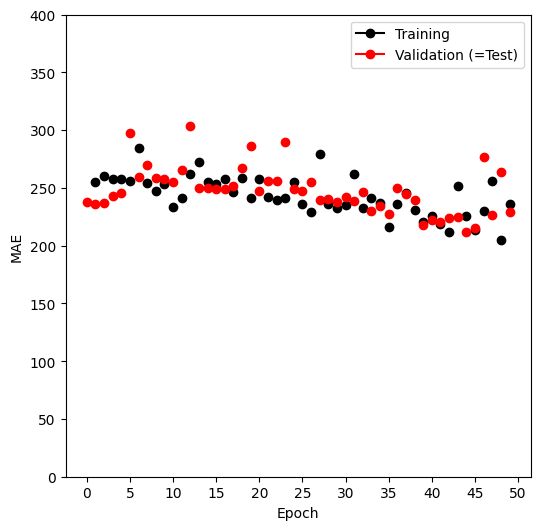

In [39]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results,
ax,
col='mae',
ylabel='MAE',
valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

In [40]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(229.5011, grad_fn=<MeanBackward0>)

In [41]:
del(Hitters,
hit_model, hit_dm,
hit_logger,
hit_test, hit_train,
X, Y,
X_test, X_train,
Y_test, Y_train,
X_test_t, Y_test_t,
hit_trainer, hit_module)

In [42]:
(mnist_train,
mnist_test) = [MNIST(root='data',
train=train,
download=True,
transform=ToTensor())
for train in [True, False]]
mnist_train

100%|██████████| 9912422/9912422 [00:01<00:00, 9385684.71it/s] 


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 114045.27it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5762748.19it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 3560181.04it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [43]:
mnist_dm = SimpleDataModule(mnist_train,
mnist_test,
validation=0.2,
num_workers=max_num_workers,
batch_size=256)

In [46]:
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


In [47]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.3))
        self._forward = nn.Sequential(
        self.layer1,
        self.layer2,
        nn.Linear(128, 10))
    def forward(self, x):
        return self._forward(x)

In [48]:
mnist_model = MNISTModel()

In [49]:
mnist_model(X_).size()

torch.Size([256, 10])

In [50]:
summary(mnist_model,
input_data=X_,
col_names=['input_size',
'output_size',
'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [55]:

num_classes = 10
mnist_module = SimpleModule.classification(mnist_model, num_classes=num_classes)

# Define a CSVLogger to log training metrics to a CSV file
mnist_logger = CSVLogger('logs', name='MNIST')

In [56]:
mnist_trainer = Trainer(deterministic=True,
max_epochs=30,
logger=mnist_logger,
callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs\MNIST

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNISTModel       | 235 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


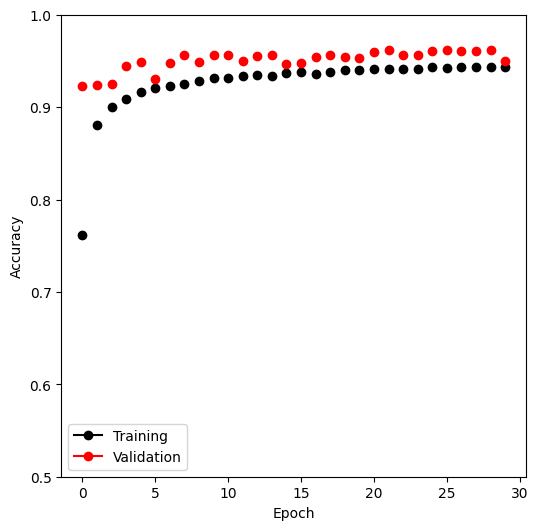

In [57]:
mnist_results = pd.read_csv(mnist_logger.experiment.
metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results,
ax,
col='accuracy',
ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

In [58]:
mnist_trainer.test(mnist_module,
datamodule=mnist_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9483000040054321
        test_loss           0.18748393654823303
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.18748393654823303, 'test_accuracy': 0.9483000040054321}]

In [59]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)
mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

TypeError: SimpleModule.classification() missing 1 required positional argument: 'num_classes'

In [ ]:
mlr_trainer = Trainer(deterministic=True,
max_epochs=30,
callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

In [ ]:
 mlr_trainer.test(mlr_module,
datamodule=mnist_dm)

In [ ]:
del(mnist_test,
mnist_train,
mnist_model,
mnist_dm,
mnist_trainer,
mnist_module,
mnist_results,
mlr_model,
mlr_module,
mlr_trainer)

In [ ]:
(cifar_train,
cifar_test) = [CIFAR100(root="data",
train=train,
download=True)
for train in [True, False]]

In [ ]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in
cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in
cifar_test.data])
cifar_train = TensorDataset(cifar_train_X,
torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,
torch.tensor(cifar_test.targets))

In [ ]:
cifar_dm = SimpleDataModule(cifar_train,
cifar_test,
validation=0.2,
num_workers=max_num_workers,
batch_size=128)

In [ ]:
for idx, (X_ ,Y_) in enumerate(cifar_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

In [ ]:
fig, axes = subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25,
replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],
        [1,2,0]),
        interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

In [ ]:
class BuildingBlock(nn.Module):
    def __init__(self,
        in_channels,
        out_channels):
            super(BuildingBlock , self).__init__()
            self.conv = nn.Conv2d(in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3,3),
            padding='same')
            self.activation = nn.ReLU()
            self.pool = nn.MaxPool2d(kernel_size=(2,2))
    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))